Deconvolution Microscopy (All Channels)
=======================================

This example partially replicates a [GlobalBioIm
example](https://biomedical-imaging-group.github.io/GlobalBioIm/examples.html)
using the [microscopy data](http://bigwww.epfl.ch/deconvolution/bio/)
provided by the EPFL Biomedical Imaging Group.

The deconvolution problem is solved using class
[admm.ADMM](../_autosummary/scico.admm.rst#scico.admm.ADMM) to solve
an image deconvolution problem with isotropic total variation (TV)
regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; \| M (\mathbf{y} - A \mathbf{x})
  \|_2^2 + \lambda \| C \mathbf{x} \|_{2,1} +
  \iota_{\mathrm{NN}}(\mathbf{x}) \;,$$

where $M$ is a mask operator, $A$ is circular convolution,
$\mathbf{y}$ is the blurred image, $C$ is a convolutional gradient
operator, $\iota_{\mathrm{NN}}$ is the indicator function of the
non-negativity constraint, and $\mathbf{x}$ is the desired image.

In [1]:
import glob
import os
import tempfile
import zipfile

import numpy as np

import jax

import imageio

try:
    import ray
except ImportError:
    raise RuntimeError("The ray package is required to run this script")

import scico.numpy as snp
from scico import functional, linop, loss, plot, util
from scico.admm import ADMM, CircularConvolveSolver
plot.config_notebook_plotting()

Define helper functions.

In [2]:
def volume_read(path, ext="tif"):
    """Read a 3D volume from a set of files in the specified directory."""

    slices = []
    for file in sorted(glob.glob(os.path.join(path, "*." + ext))):
        image = imageio.imread(file)
        slices.append(image)
    return np.dstack(slices)


def get_deconv_data(channel, cache_path=None):
    """Get deconvolution problem data from EPFL Biomedical Imaging Group."""

    # data source URL and filenames
    data_base_url = "http://bigwww.epfl.ch/deconvolution/bio/"
    data_zip_files = ["CElegans-CY3.zip", "CElegans-DAPI.zip", "CElegans-FITC.zip"]
    psf_zip_files = ["PSF-" + data for data in data_zip_files]
    # set default cache path if not specified
    if cache_path is None:
        cache_path = os.path.join(os.path.expanduser("~"), ".cache", "scico", "epfl_big")

    # if cache path exists, data is assumed to aleady be downloaded
    if not os.path.isdir(cache_path):
        os.makedirs(cache_path)
        # temporary directory for downloads
        temp_dir = tempfile.TemporaryDirectory()
        # download data and psf files for selected channel into temporary directory
        for zip_file in (data_zip_files[channel], psf_zip_files[channel]):
            data = util.url_get(data_base_url + zip_file)
            f = open(os.path.join(temp_dir.name, zip_file), "wb")
            f.write(data.read())
            f.close()
        # unzip downloaded data into cache path
        for zip_file in (data_zip_files[channel], psf_zip_files[channel]):
            with zipfile.ZipFile(os.path.join(temp_dir.name, zip_file), "r") as zip_ref:
                zip_ref.extractall(cache_path)

    # read unzipped data files into 3D arrays
    zip_file = data_zip_files[channel]
    y = volume_read(os.path.join(cache_path, zip_file[:-4])).astype(np.float32)
    zip_file = psf_zip_files[channel]
    psf = volume_read(os.path.join(cache_path, zip_file[:-4])).astype(np.float32)
    return y, psf


def block_avg(im, N):
    """Average distinct NxNxN blocks of im, return the resulting smaller image."""

    im = snp.mean(snp.reshape(im, (-1, N, im.shape[1], im.shape[2])), axis=1)
    im = snp.mean(snp.reshape(im, (im.shape[0], -1, N, im.shape[2])), axis=2)
    im = snp.mean(snp.reshape(im, (im.shape[0], im.shape[1], -1, N)), axis=3)

    return im

Get and preprocess data. We downsample the data for the purposes of
the example. Reducing the downsampling rate will be slower and more
memory-intensive. If your GPU does not have enough memory, you can try
setting the environment variable `JAX_PLATFORM_NAME=cpu` to run on CPU.
To run this example on a GPU it
[may also be necessary](https://github.com/google/jax/issues/5380) to
set environment variable `XLA_PYTHON_CLIENT_PREALLOCATE=false`.

In [3]:
downsampling_rate = 4

y_list = []
y_pad_list = []
psf_list = []
for channel in range(3):
    y, psf = get_deconv_data(channel)  # get data
    y = block_avg(y, downsampling_rate)  # downsample
    psf = block_avg(psf, downsampling_rate)
    y -= y.min()  # normalize y
    y /= y.max()
    psf /= psf.sum()  # normalize psf
    if channel == 0:
        padding = [[0, p] for p in snp.array(psf.shape) - 1]
        mask = snp.pad(snp.ones_like(y), padding)
    y_pad = snp.pad(y, padding)  # zero-padded version of y
    y_list.append(y)
    y_pad_list.append(y_pad)
    psf_list.append(psf)
y = snp.stack(y_list, axis=-1)
yshape = y.shape
del y_list

Define problem and algorithm parameters.

In [4]:
λ = 2e-6  # ℓ1 norm regularization parameter
ρ0 = 1e-3  # ADMM penalty parameter for first auxiliary variable
ρ1 = 1e-3  # ADMM penalty parameter for second auxiliary variable
ρ2 = 1e-3  # ADMM penalty parameter for third auxiliary variable
maxiter = 100  # number of ADMM iterations

Initialize ray, determine available computing resources, and put large arrays
in object store.

In [5]:
ray.init()

ngpu = 0
ar = ray.available_resources()
ncpu = int(ar["CPU"]) // 3
if "GPU" in ar:
    ngpu = int(ar["GPU"]) // 3
print(f"Running on {ncpu} CPUs and {ngpu} GPUs per process")

y_pad_list = ray.put(y_pad_list)
psf_list = ray.put(psf_list)
mask_store = ray.put(mask)

Running on 26 CPUs and 2 GPUs per process


Define ray remote function for parallel solves.

In [6]:
@ray.remote(num_cpus=ncpu, num_gpus=ngpu)
def deconvolve_channel(channel):
    y_pad = jax.device_put(ray.get(y_pad_list)[channel])
    psf = jax.device_put(ray.get(psf_list)[channel])
    mask = jax.device_put(ray.get(mask_store))
    M = linop.Diagonal(mask)
    C0 = linop.CircularConvolve(
        h=psf, input_shape=mask.shape, h_center=snp.array(psf.shape) / 2 - 0.5  # forward operator
    )
    C1 = linop.FiniteDifference(input_shape=mask.shape, circular=True)  # gradient operator
    C2 = linop.Identity(mask.shape)  # identity operator
    g0 = loss.SquaredL2Loss(y=y_pad, A=M)  # loss function (forward model)
    g1 = λ * functional.L21Norm()  # TV penalty (when applied to gradient)
    g2 = functional.NonNegativeIndicator()  # non-negativity constraint
    if channel == 0:
        print("Displaying solver status for channel 0")
        verbose = True
    else:
        verbose = False
    solver = ADMM(
        f=None,
        g_list=[g0, g1, g2],
        C_list=[C0, C1, C2],
        rho_list=[ρ0, ρ1, ρ2],
        maxiter=maxiter,
        verbose=verbose,
        x0=y_pad,
        subproblem_solver=CircularConvolveSolver(),
    )
    x_pad = solver.solve()
    x = x_pad[: yshape[0], : yshape[1], : yshape[2]]
    return (x, solver.itstat_object.history(transpose=True))

Solve problems for all three channels in parallel and extract results.

In [7]:
ray_return = ray.get([deconvolve_channel.remote(channel) for channel in range(3)])
x = snp.stack([t[0] for t in ray_return], axis=-1)
solve_stats = [t[1] for t in ray_return]

(deconvolve_channel pid=67634) Displaying solver status for channel 0
(deconvolve_channel pid=67634) Iter  Time      Objective  Primal Rsdl  Dual Rsdl
(deconvolve_channel pid=67634) -------------------------------------------------
(deconvolve_channel pid=67634)    0  2.97e+00  6.897e-02    1.059e+02  7.430e+01
(deconvolve_channel pid=67634)    1  5.88e+00  8.898e-02    5.572e+01  8.752e+01
(deconvolve_channel pid=67634)    2  8.18e+00  1.058e-01    5.023e+01  7.186e+01
(deconvolve_channel pid=67634)    3  1.06e+01  1.189e-01    6.156e+01  4.522e+01
(deconvolve_channel pid=67634)    4  1.30e+01  1.333e-01    5.683e+01  3.635e+01
(deconvolve_channel pid=67634)    5  1.53e+01  1.500e-01    4.092e+01  4.393e+01
(deconvolve_channel pid=67634)    6  1.77e+01  1.661e-01    2.699e+01  4.704e+01
(deconvolve_channel pid=67634)    7  1.99e+01  1.815e-01    2.281e+01  4.420e+01
(deconvolve_channel pid=67634)    8  2.22e+01  1.964e-01    2.341e+01  4.018e+01
(deconvolve_channel pid=67634)    9  2.

Show the recovered image.

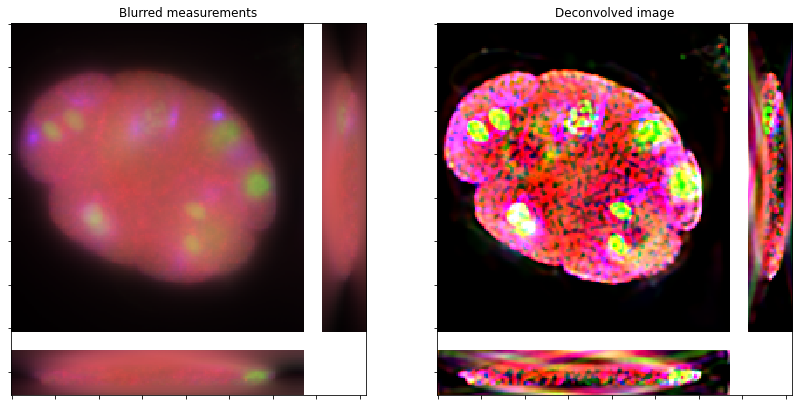

In [8]:
def make_slices(x, sep_width=10):
    """Make an image with xy, xz, and yz slices from an input volume."""

    fill_val = -1.0
    out = snp.concatenate(
        (
            x[:, :, x.shape[2] // 2],
            snp.full((x.shape[0], sep_width, 3), fill_val),
            x[:, x.shape[1] // 2, :],
        ),
        axis=1,
    )

    out = snp.concatenate(
        (
            out,
            snp.full((sep_width, out.shape[1], 3), fill_val),
            snp.concatenate(
                (
                    x[x.shape[0] // 2, :, :].transpose((1, 0, 2)),
                    snp.full((x.shape[2], x.shape[2] + sep_width, 3), fill_val),
                ),
                axis=1,
            ),
        ),
        axis=0,
    )

    out = snp.where(out == fill_val, out.max(), out)

    return out


fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot.imview(make_slices(y), title="Blurred measurements", fig=fig, ax=ax[0])
plot.imview(make_slices(x), title="Deconvolved image", fig=fig, ax=ax[1])
fig.show()

Plot convergence statistics.

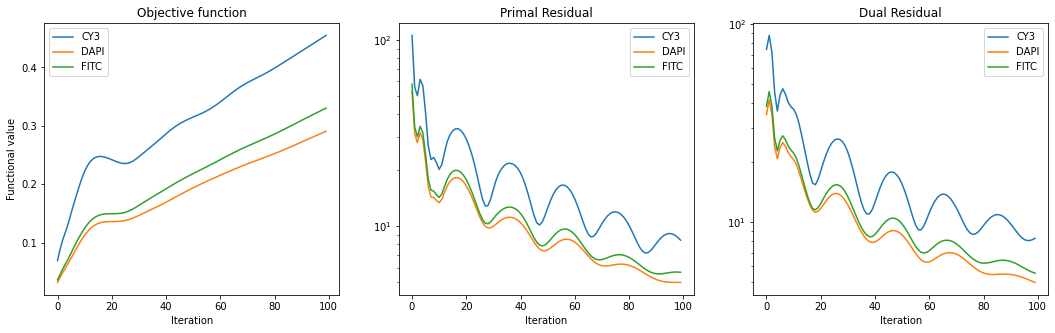

In [9]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(18, 5))
plot.plot(
    np.stack([s.Objective for s in solve_stats]).T,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    lgnd=("CY3", "DAPI", "FITC"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    np.stack([s.Primal_Rsdl for s in solve_stats]).T,
    ptyp="semilogy",
    title="Primal Residual",
    xlbl="Iteration",
    lgnd=("CY3", "DAPI", "FITC"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    np.stack([s.Dual_Rsdl for s in solve_stats]).T,
    ptyp="semilogy",
    title="Dual Residual",
    xlbl="Iteration",
    lgnd=("CY3", "DAPI", "FITC"),
    fig=fig,
    ax=ax[2],
)
fig.show()